In [1]:
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import SimParams, OptimizationParameters
from act.cell_model import TargetCell, ModuleParameters

target_cell = TargetCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles",
    cell_name="Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

sg = SyntheticGenerator(
    ModuleParameters(
        module_folder_name="original",
        cell= target_cell,
        sim_params= SimParams(
            h_v_init = -70,
            h_tstop = 300,
            h_dt = 0.01,
            h_celsius = 37,
            CI_type = "constant",
            CI_amps = [0.1, 0.2, 0.3],
            CI_dur = 290,
            CI_delay = 10,
            set_g_to=[]
        ),
        optim_params = OptimizationParameters(
            blocked_channels= []
        )
    )
)

sg.generate_synthetic_target_data("target_data.csv")

/home/mwsrgf/act-venv/lib64/python3.9/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)
--No graphics will be displayed.


Blocking: []
Total number of jobs: 3
Total number of proccessors: 192
/home/mwsrgf/proj/ACT/model/original/synthetic_0.1_0.2_0.3_


In [2]:
sg_passive = SyntheticGenerator(
    ModuleParameters(
        module_folder_name="original",
        cell= target_cell,
        sim_params= SimParams(
            h_v_init = -70,
            h_tstop = 1000,
            h_dt = 0.01,
            h_celsius = 37,
            CI_type = "constant",
            CI_amps = [-0.1],    ##################### NEGATIVE CURRENT INJECTION ###################
            CI_dur = 600,
            CI_delay = 200,
            set_g_to=[]
        ),
        optim_params = OptimizationParameters(
            blocked_channels= ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im"]
        )
    )
)

sg_passive.generate_synthetic_target_data("passive_data.csv")

Blocking: ['gbar_nap', 'gkdrbar_kdr', 'gbar_na3', 'gmbar_im']
Total number of jobs: 1
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/original/synthetic_-0.1_


(1000,)


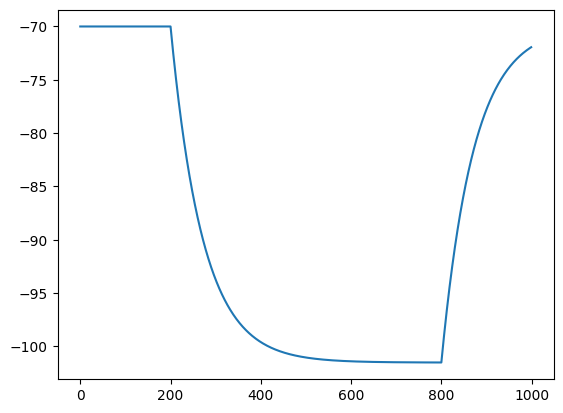

In [3]:
import numpy as np
dataset = np.loadtxt('./model/original/target/passive_data.csv', delimiter=',', skiprows=1)

V = dataset[:,0]
print(V.shape)

from matplotlib import pyplot as plt

plt.plot(V)


In [4]:
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

train_cell = TrainCell(
    hoc_file="/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/template.hoc",
    mod_folder="/home/mwsrgf/proj/ACT/data/Burster/Izhikevich_p307_orig/modfiles",
    cell_name="Burster_Izh",
    g_names = ["gbar_nap", "gkdrbar_kdr", "gbar_na3", "gmbar_im", "glbar_leak"]
)

passive_mod = PassivePropertiesModule(
    train_cell=train_cell,
    sim_params=SimParams(
            h_v_init = -70,
            h_tstop = 1000,
            h_dt = 1,    # sim forces 1ms dt
            h_celsius = 37,
            CI_type = "constant",
            CI_amps = [-0.1],    
            CI_dur = 600,
            CI_delay = 200,
            set_g_to=[]
        ),
    trace_filepath='./model/original/target/passive_data.csv',
    leak_conductance_variable="glbar_leak",
    leak_reversal_variable="el_leak"
)

In [5]:
passive_mod.set_passive_properties()

MECHANISMS already loaded.
Found 1 section(s) in this cell. Calculating the total surface area of the cell.


In [6]:
print(train_cell.passive_properties)

PassiveProperties(V_rest=-70.0, R_in=315.12453555963333, tau=72.0, Cm=0.22848109834460956, g_bar_leak=3.500798782496618e-05, cell_area=9.064641486925113e-05, leak_conductance_variable='glbar_leak', leak_reversal_variable='el_leak')


In [7]:
from act.ACTModule import ACTModule
from act.SyntheticGenerator import SyntheticGenerator
from act.act_types import  Cell, SimParams, OptimizationParameters, OptimizationParam
from act.cell_model import ModuleParameters
from act.PassivePropertiesModule import PassivePropertiesModule
from act.act_types import SimParams
from act.cell_model import TrainCell

mod = ACTModule(
    ModuleParameters(
        module_folder_name="original",
        cell= train_cell,
        target_traces_file = "target_data.csv",
        sim_params= SimParams(
            h_v_init = -70,
            h_tstop = 300,
            h_dt = 1, # sim forces 1ms dt
            h_celsius = 37,
            CI_type = "constant",
            CI_amps = [0.1, 0.2, 0.3],
            CI_dur = 290,
            CI_delay = 10,
            set_g_to=[]
        ),
        optim_params= OptimizationParameters(
            g_ranges_slices= [
                OptimizationParam(param="gbar_nap", low=0.0001, high=0.0006, n_slices=3),
                OptimizationParam(param="gkdrbar_kdr", low=0.01, high=0.056, n_slices=3),
                OptimizationParam(param="gbar_na3", low=0.01, high=0.06, n_slices=2),
                OptimizationParam(param="gmbar_im", low=0.00066667, high=0.0033, n_slices=3),
                OptimizationParam(param="glbar_leak", prediction=train_cell.passive_properties.g_bar_leak, bounds_variation=0.0, n_slices=1)
            ]
        )
    )
)

In [8]:
predicted_g_data_folder = mod.run()

RUNNING THE MODULE
LOADING TARGET TRACES
SIMULATING TRAINING DATA
Total number of jobs: 162
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/original/train
TRAINING RANDOM FOREST REGRESSOR
-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)


100%|██████████| 3/3 [00:00<00:00,  4.08it/s]

-------------------------------------------------
GENERATING ARIMA STATS
-------------------------------------------------
ARIMA order set to (4, 0, 4)



100%|██████████| 162/162 [00:21<00:00,  7.47it/s]


Evaluating random forest
MAE: 0.003325 (0.000643)
Predicted Conductances for each current injection intensity: [[1.37750000e-04 2.82160000e-02 3.11000000e-02 2.93265046e-03
  3.50079878e-05]
 [2.63750000e-04 2.34780000e-02 1.07500000e-02 2.67063413e-03
  3.50079878e-05]
 [3.18250000e-04 1.02070000e-02 3.35000000e-02 1.76740194e-03
  3.50079878e-05]]
SIMULATING PREDICTIONS
Total number of jobs: 9
Total number of proccessors: 192
MECHANISMS already loaded.
/home/mwsrgf/proj/ACT/model/original/prediction_eval0
/home/mwsrgf/proj/ACT/model/original/prediction_eval1
/home/mwsrgf/proj/ACT/model/original/prediction_eval2
SELECTING BEST PREDICTION
{'gbar_nap': 0.0002637499999999959, 'gkdrbar_kdr': 0.02347800000000029, 'gbar_na3': 0.010749999999999833, 'gmbar_im': 0.0026706341299999868, 'glbar_leak': 3.500798782496661e-05}


In [9]:
print(train_cell.predicted_g)

{'gbar_nap': 0.0002637499999999959, 'gkdrbar_kdr': 0.02347800000000029, 'gbar_na3': 0.010749999999999833, 'gmbar_im': 0.0026706341299999868, 'glbar_leak': 3.500798782496661e-05}


In [10]:
from act import ACTPlot
ACTPlot.plot_v_comparison(predicted_g_data_folder, "./model/original/target", "./model/original", [0.1, 0.2, 0.3])
ACTPlot.plot_fi_comparison("./model/original/results/frequency_data_1.npy", [0.1, 0.2, 0.3])